(example_4)=
# Example 4: Iowa-Gambling Task

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ilabcode/pyhgf/blob/master/docs/source/notebooks/Example_4_Iowa_Gambling_Task.ipynb)

In [1]:
import arviz as az
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import grad
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
from jax import jit, vjp
from jax.nn import softmax
from jax.tree_util import Partial
from pyhgf.math import binary_surprise, gaussian_surprise
from pyhgf.model import HGF
from pyhgf.utils import beliefs_propagation
from pytensor.graph import Apply, Op

jax.config.update("jax_enable_x64", True)  # this is required for the softmax

plt.rcParams["figure.constrained_layout.use"] = True

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Similarly to the [previous example](#example_3) we can also fit the Iowa Gambling Task (IGT) using the HGF. IGT is a developed form of a two-armed bandit task, with the key difference being that 1) the rewards are continuous and 2) the magnitude and the frequency of the rewards differ between the arms, or in this case - decks of cards.

In this task, participants must choose between four decks of cards, each associated with different rewards and punishments. The task is designed to measure decision-making under uncertainty and risk-taking behaviour. The task is typically divided into blocks, and the participant has to learn the reward and punishment probabilities associated with each deck. The task is designed such that two decks are disadvantageous (A and B) and two are advantageous (C and D). The advantageous decks have a higher **total value** compared to the disadvantageous decks.

*insert a picture here illustrating 10 rounds of different decks*

Building on top of Example 3, this notebook will also use missing/unobserved values in the input nodes and custom response functions, with two key additions: the input nodes will now process continuous values and a new parameter will be introduced to model a specific bias in the agent's decision-making, specifically - a preference for decks with high reward frequency.

## Simulating data

### Deck 1

Deck 1, one of the disadvantageous decks, has a baseline reward of 100 but has a high likelihood (50%) of also containing a punishment of -150 to -350. This means that in 50% of the cases, the total reward will be 100 and in the other 50% of cases it will be 100 - (150 to 350).

In [2]:
num_trials = 100

# set default value to 100.0
deck1 = np.ones(num_trials) * 100.0

# 50% chance to add something between -150 and -350
deck1 += np.random.choice(
    [-150, -175, -200, -225, -250, -275, -300, -325, -350], size=num_trials
) * np.random.binomial(1, 0.5, num_trials)

print(f"Total value of Deck 3: {deck1.sum()}")

Total value of Deck 3: -4125.0


### Deck 2

Deck 2, the other disadvantageous deck, has a baseline reward of 100 and a low likelihood (10%) of a high loss of -1250. This means that in 90% of the cases the total reward will be 100 and in 10% of the cases it will be 100 - 1250.

In [3]:
# set default value to 100.0
deck2 = np.ones(num_trials) * 100.0

# 50% chance to add something between -150 and -350
deck2 += -1250.0 * np.random.binomial(1, 0.1, num_trials)

print(f"Total value of Deck 3: {deck2.sum()}")

Total value of Deck 3: 1250.0


### Deck 3

Deck 3 is one of the advantageous decks and has the same structure as Deck 1, but with a baseline reward of 50 and 50% likelihood of a punishment of -25 to -75. Even though its baseline reward is lower than that of Deck 1, it has a higher total value due to the lower punishment magnitude.

In [4]:
# set default value to 100.0
deck3 = np.ones(num_trials) * 50.0

# 50% chance to add something between -150 and -350
deck3 += np.random.choice([-25, -50, -75], size=num_trials) * np.random.binomial(
    1, 0.5, num_trials
)

print(f"Total value of Deck 3: {deck3.sum()}")

Total value of Deck 3: 2100.0


### Deck 4

Deck 4 is the other advantageous deck, which mirrors the structure of Deck 2, but with a baseline reward of 50 and a 10% likelihood of a punishment of -250. Again, even though its baseline reward is lower than that of Deck 2, it has a higher total value due to the lower punishment magnitude.

In [5]:
# set default value to 100.0
deck4 = np.ones(num_trials) * 50.0

# 50% chance to add something between -150 and -350
deck4 += -250 * np.random.binomial(1, 0.1, num_trials)

print(f"Total value of Deck 3: {deck3.sum()}")

Total value of Deck 3: 2100.0


Below, we combine the decks into a list, standardize the values and plot the time series of the rewards for each deck.

In [6]:
decks = [deck1, deck2, deck3, deck4]

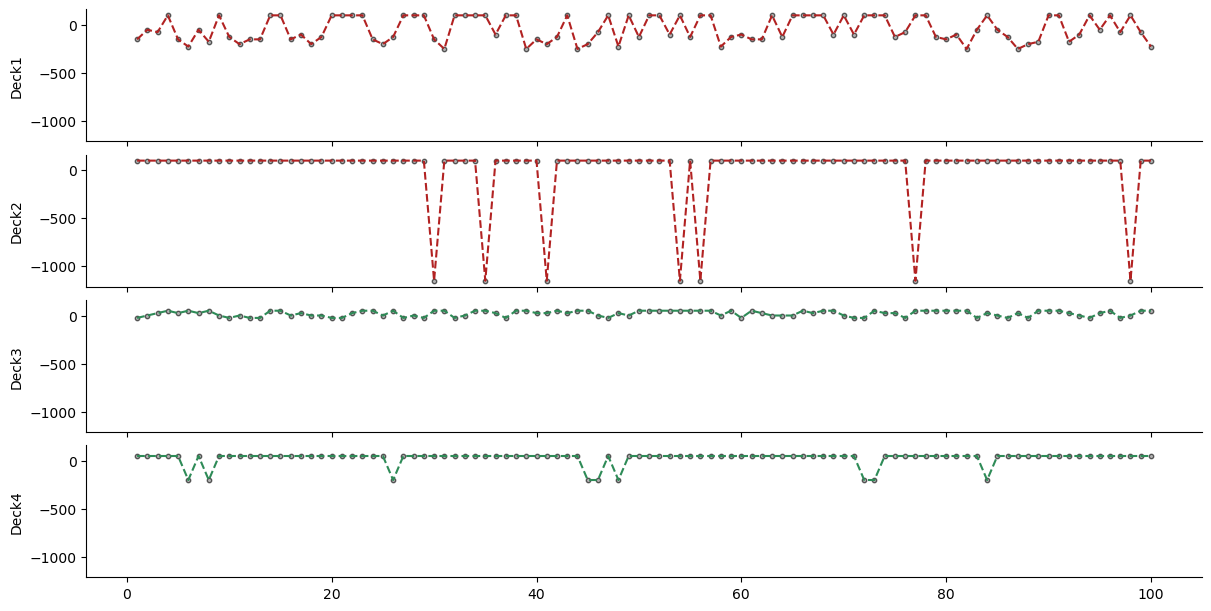

In [7]:
# Visualize the decks

# ensure equivalence between time stamps
# the HGF trials start at 1 - 0 being the prior
trials = np.arange(num_trials) + 1

_, axs = plt.subplots(figsize=(12, 6), nrows=4, sharex=True, sharey=True)

for i, u, label, color in zip(
    range(4),
    [decks[0], decks[1], decks[2], decks[3]],
    ["Deck1", "Deck2", "Deck3", "Deck4"],
    ["firebrick", "firebrick", "seagreen", "seagreen"],
):
    axs[i].scatter(
        trials, u, label="outcomes", alpha=0.6, s=10, color="gray", edgecolor="k"
    )
    axs[i].plot(trials, u, "--", color=color)
    axs[i].set_ylabel(label)
sns.despine();

# A multi-armed bandit with continuous inputs

Now we build a model with 4 HGFs, one for each deck. Every HGF will have the same structure as above - the **continuous input** nodes have a value parent - the **x1** node, which in turn has its own value parent - **x2** node. The **x1** nodes will have the *autoconnection_strength* parameter, which will model the agent's bias towards decks with high reward frequency - for Decks 2 and 4, this parameter will be lower than for Decks 1 and 3. Effectively, this means that for Decks 2 and 4, the agent will be **less** influenced by the previous value of **x1** and rely more on its parent's **x2** contribution.

### Perceptual model

In [8]:
# autoconnection_strengths
high, low = 0.8, 0.3

# Input nodes
two_levels_continuous_hgf = HGF(model_type=None).add_nodes(
    kind="continuous-input", n_nodes=4, input_precision=5.0
)

# Value parents with relevant autoconnection strength
for child, strength in zip([0, 1, 2, 3], [high, low, high, low]):
    two_levels_continuous_hgf.add_nodes(
        kind="continuous-state",
        value_children=child,
        tonic_volatility=-4.0,
        precision=5.0,
        mean=0.3,
        autoconnection_strength=strength,
    )

# Value parents to the value parents
two_levels_continuous_hgf = (
    two_levels_continuous_hgf.add_nodes(value_children=4, precision=1.0)
    .add_nodes(value_children=5, precision=1.0)
    .add_nodes(value_children=6, precision=1.0)
    .add_nodes(value_children=7, precision=1.0)
)

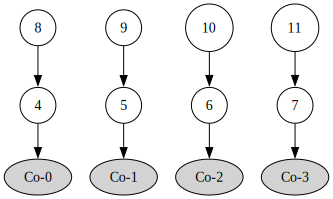

In [9]:
two_levels_continuous_hgf.plot_network()

In [10]:
# Make our input vector - time x branches
u = np.array(decks).T

In [11]:
# Let's feed our hgf the data
two_levels_continuous_hgf.input_data(input_data=u);

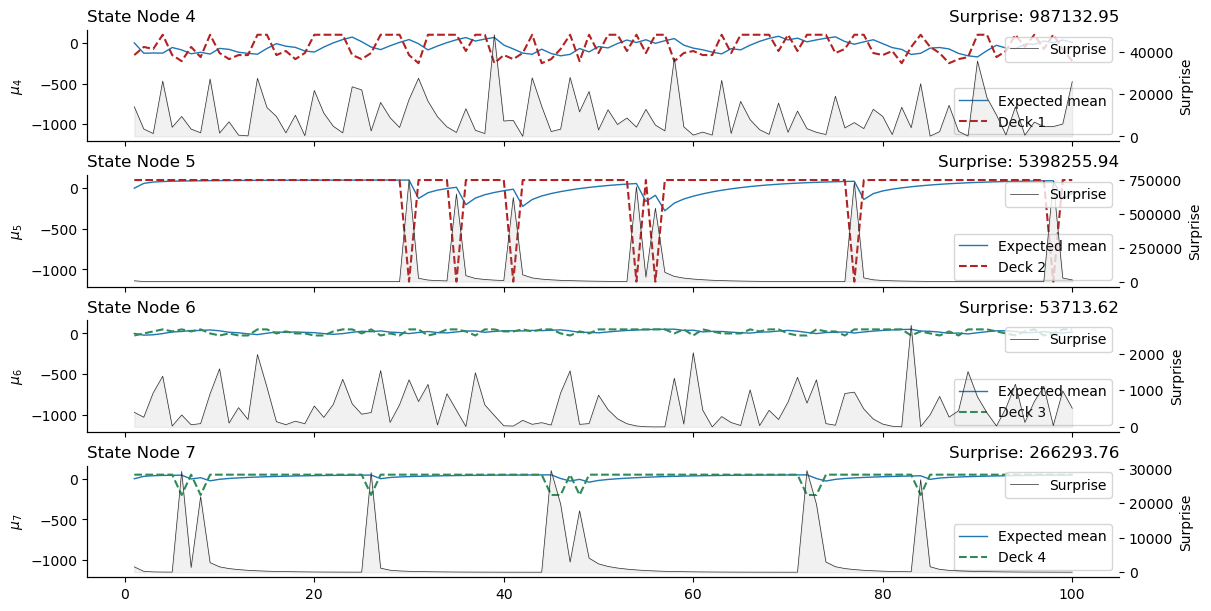

In [12]:
_, axs = plt.subplots(figsize=(12, 6), nrows=4, sharex=True, sharey=True)

two_levels_continuous_hgf.plot_nodes(node_idxs=4, axs=axs[0])
two_levels_continuous_hgf.plot_nodes(node_idxs=5, axs=axs[1])
two_levels_continuous_hgf.plot_nodes(node_idxs=6, axs=axs[2])
two_levels_continuous_hgf.plot_nodes(node_idxs=7, axs=axs[3])

for i, p, label, color in zip(
    range(4),
    [decks[0], decks[1], decks[2], decks[3]],
    ["Deck 1", "Deck 2", "Deck 3", "Deck 4"],
    ["firebrick", "firebrick", "seagreen", "seagreen"],
):
    axs[i].plot(trials, p, "--", label=label, color=color)
    axs[i].legend(loc="lower right")
sns.despine();

### Response model

Simulate responses from the participant assuming that the expected values at the first level (expected loss/reward), weigthed by the precision, is driving the probability of chosing the bandit.

In [13]:
# Simulating choices for the participant
beta_1 = 1
beta_2 = 1

means = jnp.array(
    [
        two_levels_continuous_hgf.node_trajectories[i]["expected_mean"]
        for i in range(4, 8)
    ]
)
variances = jnp.array(
    [
        1 / two_levels_continuous_hgf.node_trajectories[i]["expected_precision"]
        for i in range(4, 8)
    ]
)

In [14]:
decision_probabilities = softmax(beta_1 * means + beta_2 * variances)

In [15]:
decisions = np.array(
    [
        np.random.multinomial(n=1, pvals=decision_probabilities[:, i])
        for i in range(decision_probabilities.shape[1])
    ]
).T

In [16]:
# The participants can only see values from the branch they explored
observed = decisions

## Mask unobserved values

Here, we are not changing the network structure so we can simply use the same network than before, and provide a masked input data.

In [17]:
# masking the unobserved values (this step is optional as we are already ignoring them in the observed mask)
# using NaNs will cause intermediate updates to fail so we set the input to arbitrarily high values instead
u[~observed.T.astype(bool)] = 1e6

In [18]:
# note that we are providing the mask as parameter of the input function
two_levels_continuous_hgf.input_data(
    input_data=u,
    observed=observed.T,
);

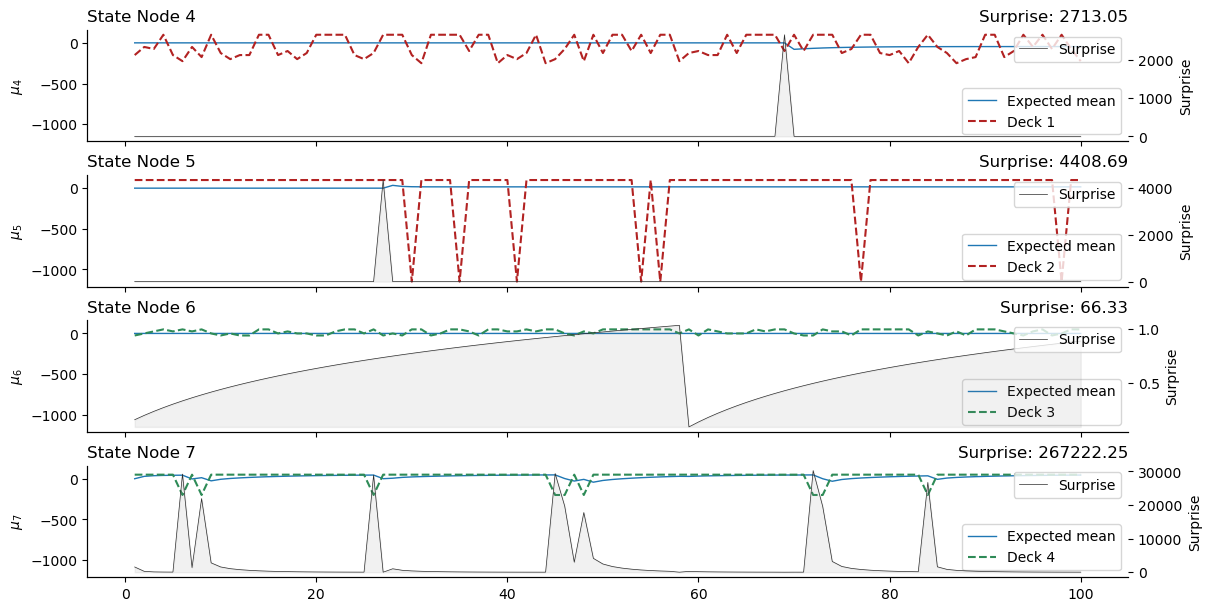

In [19]:
_, axs = plt.subplots(figsize=(12, 6), nrows=4, sharex=True, sharey=True)

two_levels_continuous_hgf.plot_nodes(node_idxs=4, axs=axs[0])
two_levels_continuous_hgf.plot_nodes(node_idxs=5, axs=axs[1])
two_levels_continuous_hgf.plot_nodes(node_idxs=6, axs=axs[2])
two_levels_continuous_hgf.plot_nodes(node_idxs=7, axs=axs[3])

for i, p, label, color in zip(
    range(4),
    [decks[0], decks[1], decks[2], decks[3]],
    ["Deck 1", "Deck 2", "Deck 3", "Deck 4"],
    ["firebrick", "firebrick", "seagreen", "seagreen"],
):
    axs[i].plot(trials, p, "--", label=label, color=color)
    axs[i].legend(loc="lower right")
sns.despine();

## Sample the network's parameters

### Create the response function

In [20]:
def response_function(
    autoregression_strength_1,
    autoregression_strength_2,
    input_data,
    decisions,
    observed,
    network,
):

    network.attributes[4][
        "autoconnection_strength"
    ] = autoregression_strength_1
    network.attributes[5][
        "autoconnection_strength"
    ] = autoregression_strength_2
    network.attributes[6][
        "autoconnection_strength"
    ] = autoregression_strength_1
    network.attributes[7][
        "autoconnection_strength"
    ] = autoregression_strength_2
    
    # run the model forward
    network.input_data(input_data=u, observed=observed)
    
    # compute decision probabilities given the belief trajectories
    expected_means = jnp.array(
        [
            two_levels_continuous_hgf.node_trajectories[i]["expected_mean"]
            for i in range(4, 8)
        ]
    )
    expected_variances = jnp.array(
        [
            1 / two_levels_continuous_hgf.node_trajectories[i]["expected_precision"]
            for i in range(4, 8)
        ]
    )
    
    # Compute the decision probabilities
    decision_probabilities = softmax(beta_1 * expected_means + beta_2 * expected_variances)
    
    # compute the binary surprise over each bandit x trials
    surprises = binary_surprise(x=decisions.T, expected_mean=decision_probabilities)
    
    # avoid numerical overflow
    surprises = jnp.where(surprises > 1e9, 1e9, surprises)
    
    # sum all the binary surprises
    surprise = surprises.sum()
    
    # returns inf if the model cannot fit somewhere
    surprise = jnp.where(jnp.isnan(surprise), jnp.inf, surprise)
    
    return -surprise

In [21]:
# fix the value of observed parameters
logp_fn = Partial(
    response_function,
    input_data=u,
    decisions=decisions.T,
    observed=observed.T,
    network=two_levels_continuous_hgf,
)

In [22]:
jitted_custom_op_jax = jit(logp_fn)

In [23]:
jitted_custom_op_jax(-600.0, 200.0)

Array(-1.02e+08, dtype=float64)

In [39]:
grad_logp_fn = jit(grad(jitted_custom_op_jax, argnums=[0, 1]))

In [40]:
grad_logp_fn(.8, .3)

(Array(-0.1265156, dtype=float64, weak_type=True),
 Array(-919.6225353, dtype=float64, weak_type=True))

In [41]:
# The CustomOp needs `make_node`, `perform` and `grad`.
class CustomOp(Op):
    def make_node(self, beta_1, beta_2):
        # Create a PyTensor node specifying the number and type of inputs and outputs

        # We convert the input into a PyTensor tensor variable
        inputs = [
            pt.as_tensor_variable(beta_1),
            pt.as_tensor_variable(beta_2),
        ]
        # Output has the same type and shape as `x`
        outputs = [pt.scalar(dtype=float)]
        return Apply(self, inputs, outputs)

    def perform(self, node, inputs, outputs):
        # Evaluate the Op result for a specific numerical input

        # The inputs are always wrapped in a list
        (beta_1, beta_2) = inputs
        result = jitted_custom_op_jax(beta_1, beta_2)
        # The results should be assigned in place to the nested list
        # of outputs provided by PyTensor. If you have multiple
        # outputs and results, you should assign each at outputs[i][0]
        outputs[0][0] = np.asarray(result, dtype="float64")

    def grad(self, inputs, output_gradients):
        # Create a PyTensor expression of the gradient
        grad_beta_1, grad_beta_2 = grad_custom_op(*inputs)

        output_gradient = output_gradients[0]
        # We reference the VJP Op created below, which encapsulates
        # the gradient operation
        return [
            output_gradient * grad_beta_1,
            output_gradient * grad_beta_2,
        ]

class GradCustomOp(Op):
    def make_node(self, beta_1, beta_2):
        # Make sure the two inputs are tensor variables
        inputs = [
            pt.as_tensor_variable(beta_1), 
            pt.as_tensor_variable(beta_2), 
        ]
        # Output has the shape type and shape as the first input
        outputs = [inp.type() for inp in inputs]
        return Apply(self, inputs, outputs)

    def perform(self, node, inputs, outputs):
        grad_beta_1, grad_beta_2 = grad_logp_fn(*inputs)

        outputs[0][0] = np.asarray(grad_beta_1, dtype=node.outputs[0].dtype)
        outputs[1][0] = np.asarray(grad_beta_2, dtype=node.outputs[1].dtype)

# Instantiate the Ops
custom_op = CustomOp()
grad_custom_op = GradCustomOp()

In [45]:
with pm.Model() as model:
    betas = pm.Beta("betas", 1.0, 1.0, shape=2)
    pm.Potential("hgf", custom_op(beta_1=betas[0], beta_2=betas[1]))
    idata = pm.sample(chains=2, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [betas]


Output()

Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([[<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>]], dtype=object)

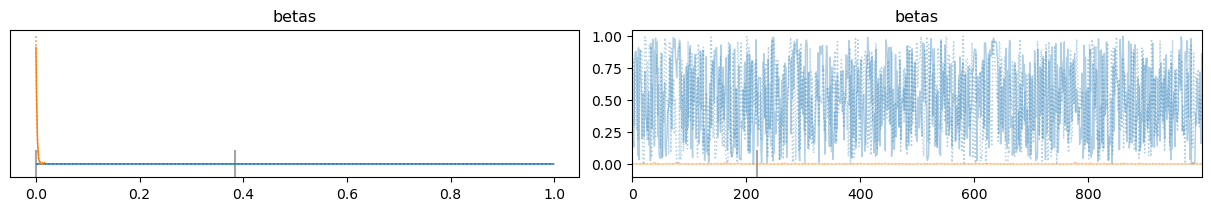

In [46]:
az.plot_trace(idata)